## 0. Imports/ Defining Fuctions for Tweepy & Extracting Tweet Features

In [1]:
from __future__ import print_function
import pandas as pd
import requests
import numpy as np
from requests_oauthlib import OAuth1
import cnfg
import tweepy
from tweepy.models import Status, ResultSet
import re
from datetime import datetime
import random

In [2]:
config = cnfg.load(".twitter_config")

oauth = OAuth1(config["consumer_key"],
               config["consumer_secret"],
               config["access_token"],
               config["access_token_secret"])

auth = tweepy.OAuthHandler(config["consumer_key"],
                           config["consumer_secret"])
#auth = tweepy.AppAuthHandler(config["consumer_key"],
#                           config["consumer_secret"])

#auth.set_access_token(config["access_token"],
#                      config["access_token_secret"])

api=tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [3]:
def view_rate_limits():
	"""
	View's key rate limits for Twitter REST API with application authentication.
	"""

	rate_limit_dict = api.rate_limit_status()['resources'] #only one API call!

	follow_remain = rate_limit_dict["friends"]['/friends/list']['remaining']

	follow_reset_time = convert_UNIX_time(rate_limit_dict["friends"]['/friends/list']['reset'])

	search_remain = rate_limit_dict['search']['/search/tweets']['remaining']

	search_reset_time = convert_UNIX_time(rate_limit_dict['search']['/search/tweets']['reset'])

	application_remain = rate_limit_dict['application']['/application/rate_limit_status']['remaining']

	application_reset_time = convert_UNIX_time(rate_limit_dict['application']['/application/rate_limit_status']['reset'])

	user_remain = rate_limit_dict['statuses']['/statuses/user_timeline']["remaining"]

	user_reset = convert_UNIX_time(rate_limit_dict['statuses']['/statuses/user_timeline']["reset"])

	print("""
		Search Remaining: {}, Search Reset: {}

		Follow Remaining: {}, Follow Reset: {}

		User Remaining: {}, User Reset: {}

		Application Remaining: {}, Application Reset: {}

		The Current time is: {}
		""".format(search_remain, search_reset_time, follow_remain, follow_reset_time, user_remain, user_reset, application_remain, application_reset_time, datetime.now().time()))


def search_twitter(query, number):
	"""
	Argument Order: query, number

	Will search twitter for the query. Query can be a list.
	Number relates to how many tweets

	Returns a list of tweets
	"""
	assert type(query) == str, "Please enter a query in the form of a string"
	assert type(number) == int, "Please enter the number of as an integer"

	return list(tweepy.Cursor(api.search, q=query, lang='en', tweet_mode='extended').items(number))

def extract_handle(tweet):
	"""
	Argument Order: tweet

	Extracts the twitter handle for a given tweet. @ symbol not included.

	Returns the handle - string type
	"""
	assert type(tweet) == Status, "Please enter in a tweet of type Status"

	return tweet.__dict__['user'].screen_name

def extract_text(tweet):
	"""
	Argument Order: tweet

	Extracts the clean text of a tweet. Remove links and emoji's
	Returns clean text of the tweet
	"""

	#this function can be mapped to a list of tweets (status type)

	assert type(tweet) == Status, "Please enter in a tweet of type Status"

	regex = r"http\S+"
	subset = ""

	emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)

	if hasattr(tweet, "text"):
		clean = re.sub(regex, subset, tweet.text.strip())
		clean = emoji_pattern.sub(subset, clean).strip()
	else:
		clean = re.sub(regex, subset, tweet.full_text.strip())
	return clean



def extract_hashtags(tweet):
	"""
	Argument Order: tweet

	Return a list of hastags present in a given tweet
	"""
	hashtags = []
	assert type(tweet) == Status, "Please enter in a tweet of type Status"

	if hasattr(tweet, "entities"):
		if tweet.entities['hashtags'] == []:
			return []
		else:
			for i in tweet.entities['hashtags']:
				hashtags.append(i['text'])
	else:
		print("No entity method!")
	return hashtags


def extract_datetime(tweet):
	"""
	Argument Order: tweet

	Returns a datetime object
	"""
	assert type(tweet) == Status, "Please enter in a tweet of type Status"

	return tweet.created_at

def extract_users_tweets(handle, number):
	"""
	Argument Order: handle, number of tweets to extract
	
	Extract's a user's tweets
	"""
	final = ResultSet() #can change to resultset later if I want

	try:
		for status in tweepy.Cursor(api.user_timeline, screen_name=handle, count=200, include_rts=True).items(number):
			final.append(status)
	except:
		print("{} is a protected user!")
		return []

	return final


def average_retweets(lst, handle):
	"""
	Argument Order: lst, handle

	Given a ResultSet of tweets, calculate the average retweet count for all tweets in ResultSet.

	Be sure to only apply this on a ResultSet that excludes retweets.

	This function would be amazing with firehose API
	"""
	assert type(lst) == ResultSet, "Please enter a ResultSet of user's tweets."

	count = 0
	
	for tweet in lst:
		count += tweet.retweet_count

	return count/len(lst)

def get_all_following(handle):
	"""
	Argument Order: handle

	Returns all the followers for a particular handle.

	Warning: This burns through rate limit
	"""
	final = []

	for friend in tweepy.Cursor(api.friends, screen_name=handle, count=200).items():
		final.append(friend.screen_name)
	return final

def get_100_following(handle):
	"""
	Argument Order: handle

	Returns the 100 most recent handles that the specified user followed.

	This function has been optimised for rate limiting.

	NOTE: If given access to firehose API - this function could be altered slightly to obtain all friends.
	"""

	final = []

	try:
		for friend in tweepy.Cursor(api.friends, screen_name=handle, count=100).items(100):
			final.append(friend.screen_name)
	except:
		print("Skipping - {} has protected tweets!".format(handle))
		return []

	return final

def second_layer_following(lst):
	"""
	Argument Order: lst

	For a given list of twitter handles, extract who they follow.

	This function will only extract the first 100 of followers for a given handle - this is due to rate limiting.

	This function will return a 'flat' list of all followers.

	NOTE: If given access to firehose API - this function could be altered slightly to obtain the entire secondary layer
	"""
	cnt = 0

	second_layer = []

	for handle in lst:
		print("processing {}".format(handle))
		second_layer.append(get_100_following(handle))
		print()
		cnt+= 1
		if cnt%10 == 0:
			print()
			print("processed {} handles from a total of {}".format(cnt, len(lst)))
			print()

	flat_second_layer = sum(second_layer, [])

	return flat_second_layer

def random_sample_lst(lst):
	"""
	Argument Order: lst

	Extracts the a random 25% of a given list
	"""
	return random.sample(lst, len(lst)//4)

def distinct(lst1, lst2):
	"""
	Argument order: source following list, accumulated source's following list
	"""

	following = lst1

	second_layer_following = lst2

	unique = set(following)

	final = [x for x in second_layer_following if x not in unique]

	return final

def convert_UNIX_time(timestamp):
    assert type(timestamp) == int, "Ensure the unix timestamp is an integer"

    return datetime.fromtimestamp(timestamp).time()

## 1. Gathering Tweets/Extracting Features & Cleaning Tweet Text

In [5]:
import preprocessor as p
import re
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import spacy
import nltk
from gensim.models import Phrases
from gensim.models.word2vec import LineSentence
from gensim.corpora import Dictionary, MmCorpus
from gensim.models.ldamulticore import LdaMulticore
from gensim import corpora, models, similarities, matutils
import gensim
import pyLDAvis
import pyLDAvis.gensim
from collections import Counter
from gensim.corpora.dictionary import Dictionary
#nlp = spacy.load('en')
import pickle
import pandas as pd
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk_stopwords = stopwords.words("english")+["health",'healthy','fitness','food','...','dont','follow','good','new','good','giving','get','like','share','week','pron','please','today','day','monday','sunday',"week","fit","amp",'february',"-pron-","rt", "via","-»","--»","--","---","-->","<--","->","<-","«--","«","«-","»","«»"]

In [6]:
nutrition_tweets = search_twitter('#nutrition', 25000)

Rate limit reached. Sleeping for: 818
Rate limit reached. Sleeping for: 810
Rate limit reached. Sleeping for: 818


Save/load data to/from pickle file

In [8]:
import pickle
with open('nutrition_tweets2`.pkl', 'wb') as f:
    pickle.dump(nutrition_tweets, f)

In [6]:
with open('nutrition_tweets.pkl', 'rb') as f:
    nutrition_tweets = pickle.load(f)

In [7]:
with open('health_tweets2.pkl', 'rb') as f:
    health_tweets = pickle.load(f)

In [8]:
hashtags = []

for tweet in nutrition_tweets:
    hashtags.append(extract_hashtags(tweet))

tweet_text = []

for tweet in nutrition_tweets:
    tweet_text.append(extract_text(tweet))
    
date_time = []

for tweet in nutrition_tweets:
    date_time.append(extract_datetime(tweet))
    
handle = []

for tweet in nutrition_tweets:
    handle.append(extract_handle(tweet))
    
location = []
for tweet in nutrition_tweets:
    location.append(tweet.place)
    

In [9]:
hashtags2 = []

for tweet in health_tweets:
    hashtags2.append(extract_hashtags(tweet))

tweet_text2 =[]

for tweet in health_tweets:
    tweet_text2.append(extract_text(tweet))
    
date_time2 = []

for tweet in health_tweets:
    date_time2.append(extract_datetime(tweet))
    
handle2 = []

for tweet in health_tweets:
    handle2.append(extract_handle(tweet))
    
location2 = []
for tweet in health_tweets:
    location2.append(tweet.place)

#### Build Dataframe (if not already) from Extracted Tweets/Features 

In [10]:
df = pd.DataFrame()
df["text"] = tweet_text
df["datetime"]= date_time
df["location"] = location
df["hashtags"] = hashtags
df["handle"] = handle

In [11]:
df2 = pd.DataFrame()
df2["text"] = tweet_text2
df2["datetime"]= date_time2
df2["location"] = location2
df2["hashtags"] = hashtags2
df2["handle"] = handle2

Creating our dataframe from pickled round of health tweets

In [12]:
df.head()

,text,datetime,location,hashtags,handle
0,RT @SunBasketMeals: Join @sunbasketmeals and @...,2018-03-06 18:09:24,None,[nutrition],billgodwin
1,Can Stress Make You Fat? - #nutrition,2018-03-06 18:09:08,None,[nutrition],svetakons
2,Researchers have found a correlation between h...,2018-03-06 18:09:04,None,"[healthnews, diet, nutrition, healthtech]",QuredApp
3,RT @jenpbradley: March is #Nutrition Month. Wa...,2018-03-06 18:09:03,None,[Nutrition],DaynaRoselli
4,Join @sunbasketmeals and @DietitianLKane NOW t...,2018-03-06 18:08:46,None,"[nutrition, morethanamealkit, NNM, giveaway]",SunBasketMeals


Creating our second dataframe from seperate pickled round of health tweets

In [13]:
df2.head()

,text,datetime,location,hashtags,handle
0,The brain can be a powerful ally but also can ...,2018-03-04 04:09:02,"Place(id='015ee5f75c3aedc2', url='https://api....","[technology, Health, body, mind, innovation, M...",AMartinezRivera
1,RT @tvkalai: #Food #Concious brings\n#Health,2018-03-04 04:08:57,None,"[Food, Concious, Health]",ManoharanS11
2,#health #beauty Buy Now: $90 Africa s Best Rel...,2018-03-04 04:08:47,None,"[health, beauty]",health_anbeauty
3,RT @TravisPSchlu: You Can Not Imagine These 10...,2018-03-04 04:08:12,None,"[health, facts, bellybutton]",lenajager4
4,RT @HealthRanger: Sugar is 8 times more addict...,2018-03-04 04:08:11,None,"[sugar, health, addiction]",monkeymasuda


Let's combine (concac) our dataframes for analysis

In [14]:
frames = [df,df2]

In [15]:
df_health = pd.concat(frames)

In [16]:
tweet_text = df_health['text']

In [17]:
df_health.head()

,text,datetime,location,hashtags,handle
0,RT @SunBasketMeals: Join @sunbasketmeals and @...,2018-03-06 18:09:24,None,[nutrition],billgodwin
1,Can Stress Make You Fat? - #nutrition,2018-03-06 18:09:08,None,[nutrition],svetakons
2,Researchers have found a correlation between h...,2018-03-06 18:09:04,None,"[healthnews, diet, nutrition, healthtech]",QuredApp
3,RT @jenpbradley: March is #Nutrition Month. Wa...,2018-03-06 18:09:03,None,[Nutrition],DaynaRoselli
4,Join @sunbasketmeals and @DietitianLKane NOW t...,2018-03-06 18:08:46,None,"[nutrition, morethanamealkit, NNM, giveaway]",SunBasketMeals


#### Cleaning Tweet Text

In [18]:
tweets = list(map(lambda x: x.replace("#", ""), tweet_text))
tweet_text = list(map(lambda x: x.replace("&amp;", "&"), tweets))
tweets = list(map(lambda x: x.replace("&gt;", "greater than"), tweet_text))
tweet_text = list(map(lambda x: x.replace("&lt;", "less than"), tweets))
tweets = list(map(lambda x: x.replace("&amp;", "&"), tweet_text))
tweet_text = list(map(lambda x: x.replace("/", ""), tweets))
tweets = list(map(lambda x: x.replace("...", ""), tweet_text))
tweet_text = list(map(lambda x: x.replace("\u200d", ""), tweets))
tweets = list(map(lambda x: x.replace("\U0001f986", ""), tweet_text))
tweet_text = list(map(lambda x: x.replace("\U0001f942", ""), tweets))
tweets = list(map(lambda x: x.replace("\U0001f92f", ""), tweet_text))
tweet_text = list(map(lambda x: x.replace("\U0001f911", ""), tweets))
tweets = list(map(lambda x: x.replace("$", ""), tweet_text))
tweet_text = list(map(lambda x: x.replace("n't", ""), tweets))
tweets = list(map(lambda x: x.replace("ç", "c"), tweet_text))
tweet_text = list(map(lambda x: x.replace("'ll", ""), tweets))

In [19]:
clean_tweets = []
for text in tweet_text:
    clean_tweets.append(p.clean(text))

In [20]:
import string
translator = str.maketrans('', '', string.punctuation)

tweets = []
for text in clean_tweets:
    tweets.append((str(text).translate(translator)))  

Let's make all words lowercase and lemmatize for consistency

In [21]:
tweet = []
for words in tweets:
    tweet.append(words.lower())

In [22]:
wordnet_lemmatizer = WordNetLemmatizer()
final_tweets = []
for words in tweet:
    final_tweets.append(wordnet_lemmatizer.lemmatize(words))

Optional: Split/remove stop words for vectorizing (other methods will automatically split for us)

In [7]:
len(nutrition_tweets)

25000

## 2. Topic Modeling with LDA/NMF and Word2Vec

#### Pre-Processing:Count Vectorization

In [25]:
count_vectorizer = CountVectorizer(min_df = 10, ngram_range=(1, 2), max_df=.5,
                                   stop_words=nltk_stopwords, token_pattern="\\b[a-z][a-z]+\\b")
count_vectorizer.fit(final_tweets)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.5, max_features=None, min_df=10,
        ngram_range=(1, 2), preprocessor=None,
        stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs',...ron-', 'rt', 'via', '-»', '--»', '--', '---', '-->', '<--', '->', '<-', '«--', '«', '«-', '»', '«»'],
        strip_accents=None, token_pattern='\\b[a-z][a-z]+\\b',
        tokenizer=None, vocabulary=None)

In [26]:
counts = count_vectorizer.transform(final_tweets).transpose()

In [27]:
id2word = dict((v, k) for k, v in count_vectorizer.vocabulary_.items())

In [28]:
corpus = matutils.Sparse2Corpus(counts)

#### Create LDA Model

In [30]:
numpy.seterr(invalid='warn')

NameError: name 'numpy' is not defined

In [29]:
lda = models.LdaModel(corpus=corpus, num_topics=10, id2word=id2word, minimum_probability=.03, passes=10)

/Users/hector/anaconda/lib/python3.6/site-packages/gensim/matutils.py:995: RuntimeWarning: invalid value encountered in subtract
  result = psi(alpha) - psi(np.sum(alpha))


KeyboardInterrupt: 

Let's view our topics before visualizing

In [ ]:
lda.print_topics()

Now, let's create a WordClous for more intuitive visualization

In [36]:
# helper function to create word clouds
def create_wordcloud(text_list, mask, filename, n_words=100):
    wordcloud = WordCloud(background_color="white", stopwords=STOPWORDS, mask=mask, max_font_size=100, max_words=n_words, width=600, height=600)
    wordcloud.generate(" ".join(text_list))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    if filename:
        plt.savefig(filename, dpi=600)
    plt.show();

In [33]:
from scipy.misc import imread

In [34]:
Mindful_Mask = imread('Meditation-Silhouette.jpg')

/Users/hector/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


NameError: name 't' is not defined

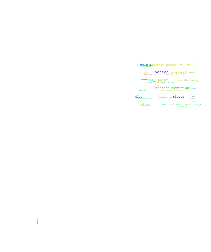

In [35]:
from wordcloud import WordCloud, STOPWORDS

import matplotlib.pyplot as plt
%matplotlib inline  

plt.figure()
plt.imshow(WordCloud(background_color="white",mask=Mindful_Mask).fit_words(lda.show_topic(6, 200)))
plt.axis("off")
plt.title("Topic #" + str(t))
plt.savefig('mindfil.png')
plt.show()

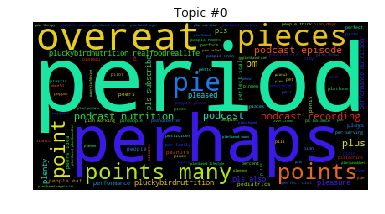

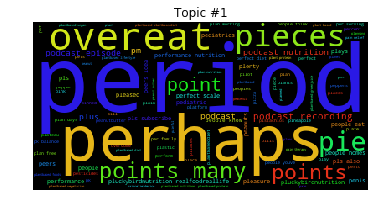

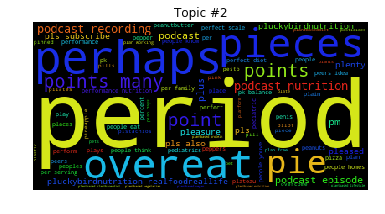

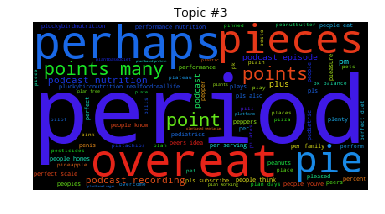

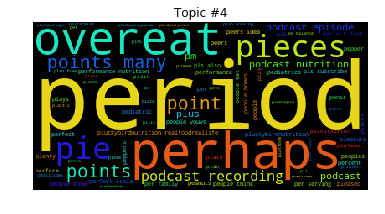

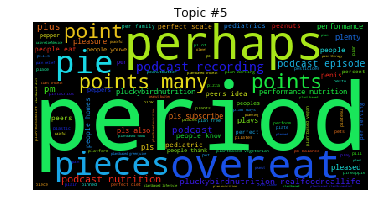

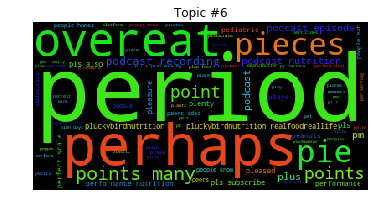

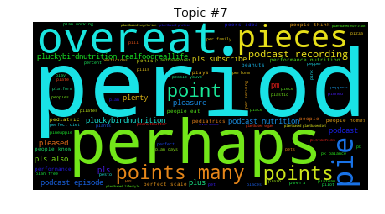

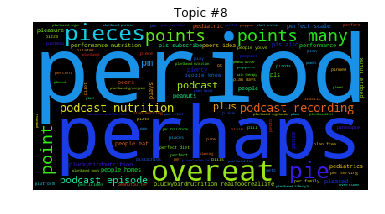

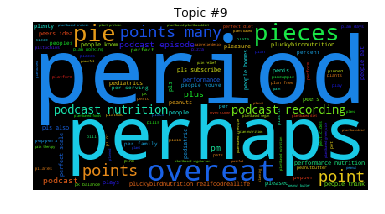

In [37]:
from wordcloud import WordCloud, STOPWORDS

import matplotlib.pyplot as plt
%matplotlib inline  

for t in range(lda.num_topics):
    plt.figure()
    plt.imshow(WordCloud().fit_words(lda.show_topic(t, 200)))
    plt.axis("off")
    plt.title("Topic #" + str(t))
    plt.show()

#### Additional Visualization for our LDA Topics Using pyLDAvis 

In [24]:
import pyLDAvis.gensim as gensimvis
import pyLDAvis
import gensim
from gensim import corpora
from gensim.utils import smart_open, simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

First, let's filter out our stop words

In [25]:
filter_stop = []
for word in final_tweets:
    list_form = word.split()
    filter_stop.append(list_form)

In [26]:
#word_tokens = []
#for word in final_tweets:
#    word_tokens.append(word_tokenize(word))

In [27]:
#filtered = [x for x in final_tweets if x not in nltk_stopwords]

In [28]:
resultwords  = []
for line in filter_stop:
    for word in line:
        if word not in nltk_stopwords:
            resultwords.append(word)
            result = ' '.join(word)

In [29]:
len(filter_stop)

34871

In [32]:
len(gensim_format_tweets)

394368

In [31]:
gensim_format_tweets = []
for word in resultwords:
    list_form = word.split()
    gensim_format_tweets.append(list_form)

In [33]:
gensim_dictionary = Dictionary(filter_stop)

In [34]:
gensim_dictionary.filter_extremes(no_below=20,no_above=.2)
gensim_dictionary.compactify() # remove gaps after words that were removed

In [35]:
def bag_of_words_generator(lst, dictionary):
    assert type(dictionary) == Dictionary, "Please enter a Gensim Dictionary"
    for i in lst: 
        yield dictionary.doc2bow(i)

In [36]:
corpus_path = '/Users/hector/Documents/Hernandez_Metis/Project4'

In [37]:
MmCorpus.serialize(corpus_path+"{}.mm".format("Tweets"), bag_of_words_generator(gensim_format_tweets, gensim_dictionary))

In [38]:
corpus = MmCorpus(corpus_path+"{}.mm".format("Tweets"))

In [39]:
lda2 = LdaMulticore(corpus, num_topics=12, minimum_probability=0.03, id2word=gensim_dictionary, passes=10)

/Users/hector/anaconda/lib/python3.6/site-packages/gensim/matutils.py:995: RuntimeWarning: invalid value encountered in subtract
  result = psi(alpha) - psi(np.sum(alpha))
/Users/hector/anaconda/lib/python3.6/site-packages/gensim/matutils.py:995: RuntimeWarning: invalid value encountered in subtract
  result = psi(alpha) - psi(np.sum(alpha))
/Users/hector/anaconda/lib/python3.6/site-packages/gensim/matutils.py:995: RuntimeWarning: invalid value encountered in subtract
  result = psi(alpha) - psi(np.sum(alpha))
Process ForkPoolWorker-3:
  File "/Users/hector/anaconda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Process ForkPoolWorker-2:
Process ForkPoolWorker-1:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/hector/anaconda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/hector/anaconda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*se

KeyboardInterrupt: 

In [ ]:
lda2.print_topics()

In [ ]:
#%%time
#lda2 = models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=15, passes=10)
                                      
#lda2.save('health_tweets.model')

In [ ]:
import pyLDAvis.gensim
import gensim
import pyLDAvis
import pyLDAvis.sklearn
from __future__ import division

#import graphlab as gl
import pandas as pd
import pyLDAvis
#import pyLDAvis.graphlab

pyLDAvis.enable_notebook()

In [ ]:
vis_data = gensimvis.prepare(lda2, corpus, gensim_dictionary)
pyLDAvis.display(vis_data)

In [ ]:
from wordcloud import WordCloud, STOPWORDS

import matplotlib.pyplot as plt
%matplotlib inline  

for t in range(lda2.num_topics):
    plt.figure()
    plt.imshow(WordCloud().fit_words(lda2.show_topic(t, 200)))
    plt.axis("off")
    plt.title("Topic #" + str(t))
    plt.show()

#### Next, let's try Word2Vec using Gensim

In [40]:
texts = [[word for word in document.lower().split() if word not in nltk_stopwords]
         for document in final_tweets]

In [41]:
model = gensim.models.Word2Vec(texts, size=100, window=5, min_count=25, workers=4,sg=1)

We'll also create a second, more selective model for visualizations

In [42]:
model2 = gensim.models.Word2Vec(texts, size=100, window=5, min_count=200, workers=4,sg=1) 

Let's explore our first model & vocab

In [43]:
list(model.wv.vocab.items())[:15]

[('join', <gensim.models.keyedvectors.Vocab at 0x1a544ea208>),
 ('talk', <gensim.models.keyedvectors.Vocab at 0x1a544ea2e8>),
 ('things', <gensim.models.keyedvectors.Vocab at 0x1a544ea390>),
 ('nutrition', <gensim.models.keyedvectors.Vocab at 0x1a544ea3c8>),
 ('question', <gensim.models.keyedvectors.Vocab at 0x1a544ea320>),
 ('use', <gensim.models.keyedvectors.Vocab at 0x1a544ea358>),
 ('stress', <gensim.models.keyedvectors.Vocab at 0x1a544ea400>),
 ('make', <gensim.models.keyedvectors.Vocab at 0x1a544ea438>),
 ('fat', <gensim.models.keyedvectors.Vocab at 0x1a544ea470>),
 ('researchers', <gensim.models.keyedvectors.Vocab at 0x1a544ea4a8>),
 ('found', <gensim.models.keyedvectors.Vocab at 0x1a544ea4e0>),
 ('high', <gensim.models.keyedvectors.Vocab at 0x1a544ea518>),
 ('blood', <gensim.models.keyedvectors.Vocab at 0x1a544ea550>),
 ('pressure', <gensim.models.keyedvectors.Vocab at 0x1a544ea588>),
 ('higher', <gensim.models.keyedvectors.Vocab at 0x1a544ea5c0>)]

In [44]:
model.most_similar('mentalhealth' ,topn=8)

/Users/hector/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('connection', 0.8347339034080505),
 ('mentalhealthmatters', 0.7912007570266724),
 ('houston', 0.7511838674545288),
 ('mindfulness', 0.7438750267028809),
 ('depression', 0.714052140712738),
 ('psychology', 0.7046579122543335),
 ('htt…', 0.6941328644752502),
 ('loneliness', 0.6797957420349121)]

In [45]:
model.similarity('yoga','strength')

/Users/hector/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


0.42473495138097006

In [46]:
# Compute cosine_similarity
model.n_similarity(['woman', 'girl'], ['man', 'wellness'])

/Users/hector/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `n_similarity` (Method will be removed in 4.0.0, use self.wv.n_similarity() instead).
  


0.6898691615395741

In [82]:
model.doesnt_match("yoga foods crossfit warrior".split())

/Users/hector/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `doesnt_match` (Method will be removed in 4.0.0, use self.wv.doesnt_match() instead).
  """Entry point for launching an IPython kernel.


'foods'

Great, now let's visualiz our Word2Vec results:

In [84]:
from sklearn.manifold import TSNE

def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.savefig('health_tweets3.png')
    plt.show()

/Users/hector/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


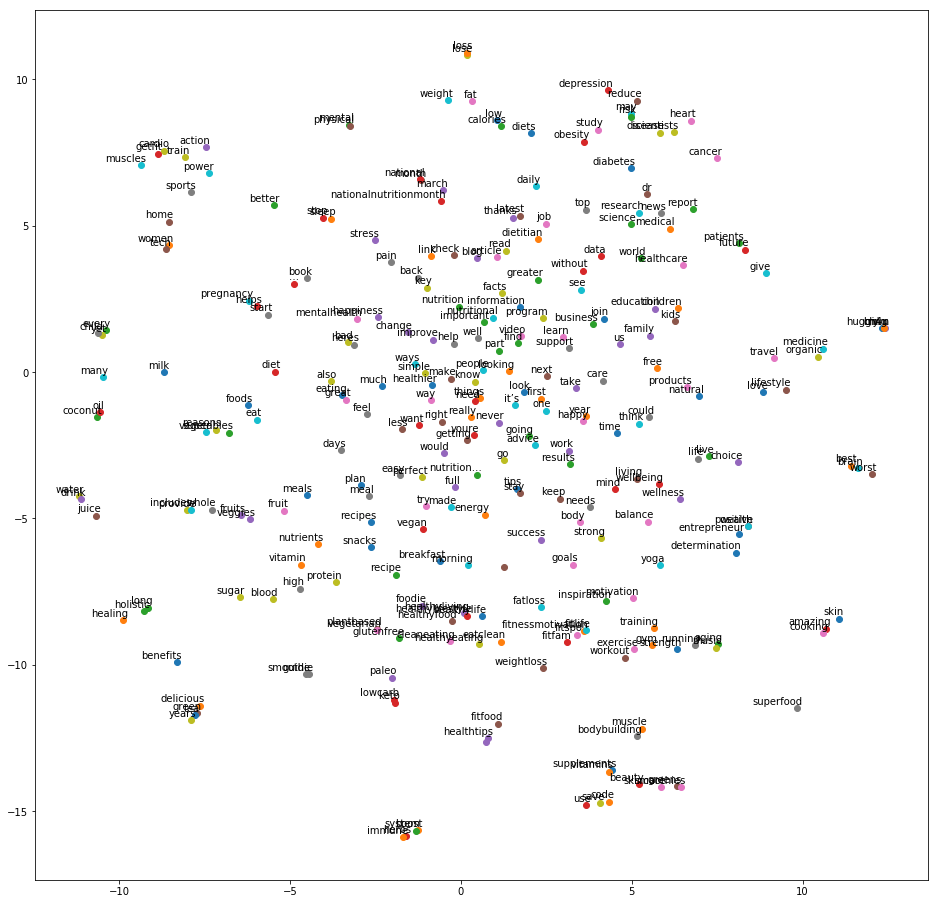

In [85]:
tsne_plot(model2)

/Users/hector/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


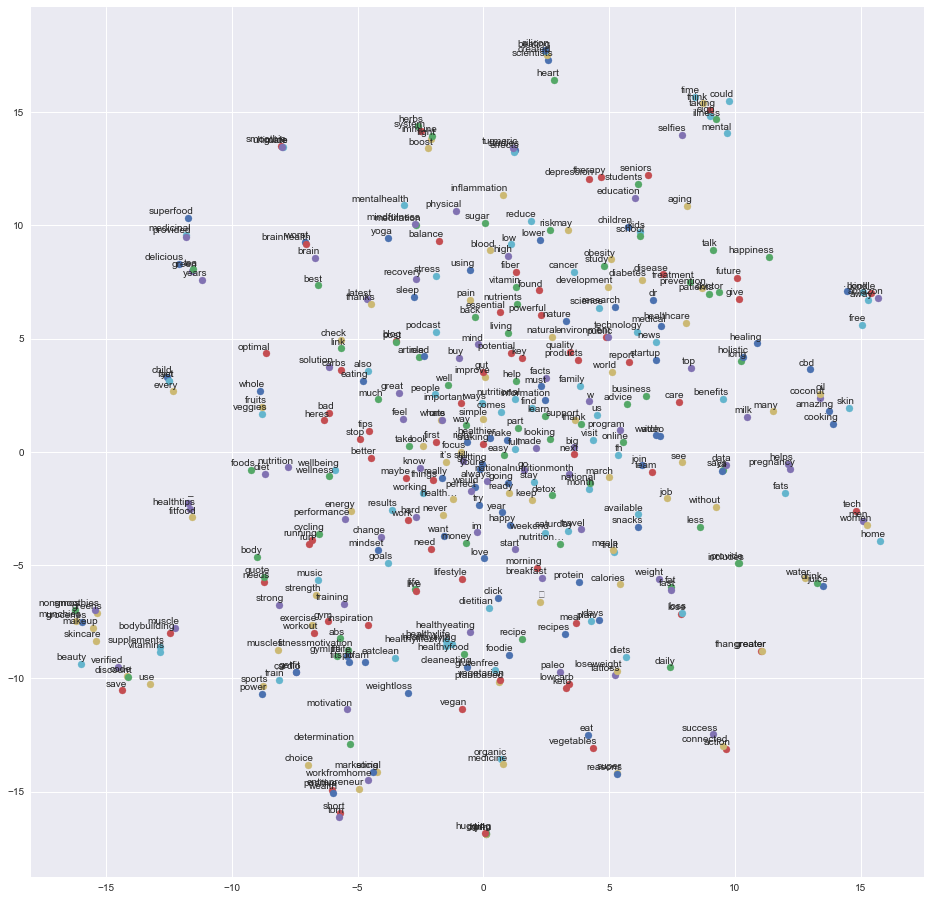

In [555]:
tsne_plot(model2)

#### Finally, Let's try a different approach to topic modeling: TFIDF+NMF

In [86]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn import metrics

TFIDF Vectorization

In [87]:
tfidf_vectorizer = TfidfVectorizer(max_features=25000, stop_words=nltk_stopwords, ngram_range=(0,2))

tfidf_matrix = tfidf_vectorizer.fit_transform(final_tweets) #try .todense9#fit the vectorizer to synopses

print(tfidf_matrix.shape)

(34134, 25000)


In [88]:
terms = tfidf_vectorizer.get_feature_names()

NMF Topic Model

In [89]:
n_samples = 2000
n_features = 1000
n_topics = 15
n_top_words = 20

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [90]:
nmf = NMF(n_components=15, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf_matrix)

In [91]:
# Taking a look at our Features/Topics
print("\nTopics in NMF model:")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)


Topics in NMF model:
Topic #0:
 nutrition diet wellness weightloss exercise body workout diet nutrition help eating healthyeating lifestyle life know protein vegan great make weight
Topic #1:
 eat vegetables vegetables super reasons eat foods nutrition super foods super reasons vegetables diet vegan nutrition diet foods eat vegan diet nutrition eat everyday everyday nutrition diet mindbody cinnamon long
Topic #2:
 lifestyle nutrition organic lifestyle nutrition mlm mlm hh4u hh4u organic medicine hh4u hugging medicine hugging mlm cry cry organic medicine lifestyle nutrition mlm crypto crypto crypto btc btc
Topic #3:
nutrition foods eat nutrition eat foods  nutrition foods affect affect bodies bodies nutrition affect bodies foods eat label whole eat everyday everyday nutrition facts diet mindbody mindbody wellness label everyday
Topic #4:
green tea tea green  greentea nutrition greentea tea superfood years green superfood consumed provided delicious consumed years medicinal benefits del

## 3. Clustering: K-means & Hierarchical

In [129]:
from sklearn.cluster import KMeans
import numpy as np
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import scale
from sklearn.decomposition import TruncatedSVD
import seaborn as sns

In [94]:
def get_cluster_centers(X, labels, k_num):
    CC_list = []
    for k in range(k_num):
        # get the mean coordinates of each cluster
        CC_list.append(np.mean(X[labels == k], axis = 0))
    return CC_list

In [95]:
def get_SSE(X, labels):
    k_num = len(np.unique(labels))
    CC_list = get_cluster_centers(X, labels, k_num)
    CSEs = []
    for k in range(k_num):
        # for each cluster of k we get the coordinates of how far off each point is to the cluster
        error_cords = X[labels == k] - CC_list[k]
        # square the coordinates and sum to get the magnitude squared
        error_cords_sq = error_cords ** 2
        error_mag_sq = np.sum(error_cords_sq, axis = 1)
        # since we already have the magnitude of the error squared we can just take the sum for the cluster
        CSE = np.sum(error_mag_sq)
        CSEs.append(CSE)
    # sum each cluster's sum of squared errors
    return sum(CSEs)

#### K-Means Clustering

fit nmf topics for kmeans clustering

In [96]:
reduced_tweets = tfidf_vectorizer.fit_transform(final_tweets)

In [97]:
nmf_reduced = nmf.fit_transform(reduced_tweets)

In [109]:
tweet_word_list = tfidf_vectorizer.get_feature_names()
components = nmf.components_
tweet_labels = kmeans.labels_

In [101]:
# examine the top 20 words associated with each latent topic
for index,values in enumerate(components):
    print("topic {}".format(index))
    temp = list(zip(positive_word_list, components[index]))
    print(sorted(temp, key=lambda x: x[1], reverse=True)[:20],"\n")

topic 0
[('', 20.600398787664762), ('nutrition', 1.6666124396837112), ('diet', 0.5624619455923086), ('wellness', 0.4265766803540049), ('weightloss', 0.35229191477110666), ('exercise', 0.3253472550589701), ('body', 0.30922398148328917), ('workout', 0.29224921939264004), ('diet nutrition', 0.26604037161718047), ('help', 0.26109608483394375), ('eating', 0.2538146412056473), ('healthyeating', 0.25329563548291845), ('lifestyle', 0.23362346594951808), ('life', 0.2259813839438323), ('know', 0.21823009908444144), ('protein', 0.2176448107551581), ('vegan', 0.21744426459922145), ('great', 0.21665891332847056), ('make', 0.21090485512573576), ('weight', 0.20537212355523465)] 

topic 1
[('', 2.4845215080974286), ('eat vegetables', 1.870572934731329), ('vegetables super', 1.8701880742128585), ('reasons eat', 1.8690425340078372), ('foods nutrition', 1.8533996547902905), ('super foods', 1.8515020910433435), ('super', 1.7887414417974445), ('reasons', 1.7881237515796677), ('vegetables', 1.71503954466379

In [137]:
ns = np.arange(4, 20, 1)
inertias = []
silhouettes = []

for n in ns:
    kmeans = KMeans(n_clusters=n, init="k-means++", random_state=123)
    kmeans.fit(nmf_reduced)
    inertias.append(kmeans.inertia_)
    labels = kmeans.labels_
    # only a sample was used to calculate silhouette score because of memory errors
    silhouettes.append(silhouette_score(nmf_reduced, labels, metric='cosine', sample_size=5000))

First, let's turn our matrix into a dataframe

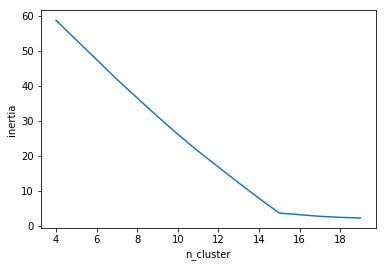

In [138]:
# plot the inertia scores and look for the kink in the curve
plt.plot(ns, inertias)
plt.xlabel('n_cluster')
plt.ylabel('inertia');

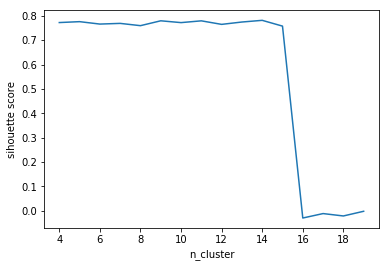

In [139]:
# plot the silhouettte scores
plt.plot(ns, silhouettes)
plt.xlabel('n_cluster')
plt.ylabel('sihouette score');

In [121]:

# based on inertia and silhouette scores, a cluster size of 6 was selected
kmeans = KMeans(n_clusters=15, init="k-means++", random_state=824)
kmeans.fit(nmf_reduced)
positive_labels = kmeans.labels_
print("Inertia score: {}".format(kmeans.inertia_))
print("Silhouette score: {}".format(silhouette_score(nmf_reduced, positive_labels, metric='cosine', sample_size=5000, random_state=824)))

Inertia score: 3.582586597458313
Silhouette score: 0.7721175864558831


#### Visualizing Clusters

In [122]:
df_reduced = pd.DataFrame(nmf_reduced)
df_reduced['tweets'] = final_tweets
df_reduced['labels'] = tweet_labels

In [124]:
# examine the number of reviews for in each cluster
for cluster in range(len(set(labels))):
    print("Cluster {} has {} tweets.".format(cluster, sum(labels==cluster)))

Cluster 0 has 17855 tweets.
Cluster 1 has 309 tweets.
Cluster 2 has 243 tweets.
Cluster 3 has 113 tweets.
Cluster 4 has 148 tweets.
Cluster 5 has 125 tweets.
Cluster 6 has 177 tweets.
Cluster 7 has 97 tweets.
Cluster 8 has 124 tweets.
Cluster 9 has 160 tweets.
Cluster 10 has 227 tweets.
Cluster 11 has 185 tweets.
Cluster 12 has 134 tweets.
Cluster 13 has 110 tweets.
Cluster 14 has 156 tweets.
Cluster 15 has 11888 tweets.
Cluster 16 has 190 tweets.
Cluster 17 has 1448 tweets.
Cluster 18 has 445 tweets.


In [126]:
tsne = TSNE(n_components=2, perplexity=40, n_iter=500, random_state=824)
tsne_positive = tsne.fit_transform(nmf_reduced)

In [134]:
df_tsne_tweets = pd.DataFrame(tsne_positive, columns=["tsne_x", "tsne_y"])
df_tsne_tweets["Cluster"] = tweet_labels
df_tsne_tweets.shape

(34134, 3)

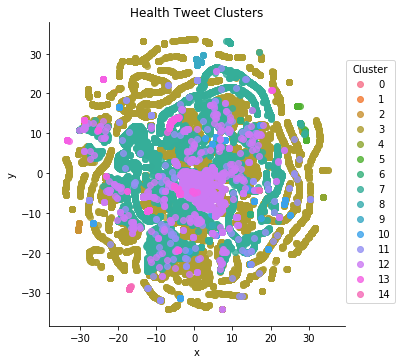

In [136]:
# visualize the tweets review clusters using t-SNE
tsne_positive = sns.lmplot("tsne_x", "tsne_y", data=df_tsne_tweets, fit_reg=False, hue="Cluster")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Health Tweet Clusters");

In [414]:
num_clusters = 15

km = KMeans(n_clusters=num_clusters, n_jobs=-1, random_state=200)

km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

order_centroids = km.cluster_centers_.argsort()[:, ::-1]

In [415]:
mu_tweet = km.cluster_centers_
mu_tweet.shape

(12, 25000)

Add our k-means labels to the datafram for plotting:

In [ ]:
df_km['category'] = km.labels_

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def draw(ax, df):
    colormap = { 0: 'red', 1: 'green', 2: 'blue', 3: 'orange' }
    colors = df_km.apply(lambda row: colormap[row.category], axis=1)

    ax.scatter(df['fish'], df['penni'], df['cat'], c=colors, s=100, alpha=0.5)
    ax.set_xlabel('Fish')
    ax.set_ylabel('Penni')
    ax.set_zlabel('Cat')

chart_count_vert = 5
chart_count_horiz = 5
number_of_graphs = chart_count_vert * chart_count_horiz

fig = plt.figure(figsize=(3 * chart_count_horiz, 3 * chart_count_vert))

for i in range(number_of_graphs):
    ax = fig.add_subplot(chart_count_horiz, chart_count_vert, i + 1, projection='3d', azim=(-360 / number_of_graphs) * i)
    draw(ax, df)

#### Finally, Let's try Hierarchical clustering

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(nmf_reduced)

In [ ]:
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=titles);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clusters

In [ ]:
#fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5), sharex=True)
#k_clusters = range(2,20)
#ax1.plot(k_clusters, Sil_coefs)
#ax1.set_xlabel('number of clusters')
#ax1.set_ylabel('silhouette coefficient')

# plot here on ax2
#ax2.plot(k_clusters, SSEs)
#ax2.set_xlabel('number of clusters')
#ax2.set_ylabel('SSE');

In [443]:
km.cluster_centers_.argsort()[:, ::-1]

array([[20989,     0, 19552, ..., 16665, 16666, 12499],
       [    0, 23415, 14283, ...,  7644,  7869,  6278],
       [    0, 19593, 17883, ..., 16662, 16663, 12499],
       [    0, 22772,  2034, ..., 16641, 16642, 12499],
       [    0, 19927,  1343, ..., 16667, 16668, 12499],
       [    0, 23300, 23289, ..., 16585, 16586, 12499]])

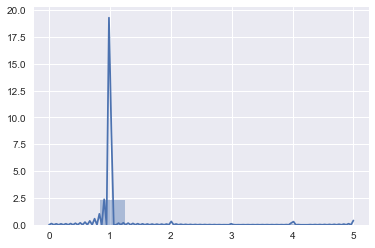

In [432]:
### Viewing Cluster Distribution
import seaborn as sns
sns.set(color_codes=True)
import numpy as np
%matplotlib inline

plt.autoscale()
sns.distplot(km.labels_, bins=12)
plt.show()

Print out the top words in our clusters

In [446]:
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = tfidf_vectorizer.get_feature_names()
for i in range(num_clusters):
    top_ten_words = [terms[ind] for ind in order_centroids[i, :3]]
    print("Cluster {}: {}".format(i, ' '.join(top_ten_words)))

Top terms per cluster:
Cluster 0: success  seems connected
Cluster 1:  wellness nutrition
Cluster 2:  selfies time psychologists think
Cluster 3:  vegetable bowl
Cluster 4:  silicon beating beating heart
Cluster 5:  weight loss weight


IndexError: index 6 is out of bounds for axis 0 with size 6

Transform TFIDF Matrix with TSNE for Visualization of K-Mean Clusters

In [447]:
k = 12
tfs_reduced = TruncatedSVD(n_components=k, random_state=0).fit_transform(tfidf_matrix)

In [448]:
tfs_embedded = TSNE(n_components=2, perplexity=40, verbose=2).fit_transform(tfs_reduced)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 21295 samples in 0.020s...
[t-SNE] Computed neighbors for 21295 samples in 6.151s...
[t-SNE] Computed conditional probabilities for sample 1000 / 21295
[t-SNE] Computed conditional probabilities for sample 2000 / 21295
[t-SNE] Computed conditional probabilities for sample 3000 / 21295
[t-SNE] Computed conditional probabilities for sample 4000 / 21295
[t-SNE] Computed conditional probabilities for sample 5000 / 21295
[t-SNE] Computed conditional probabilities for sample 6000 / 21295
[t-SNE] Computed conditional probabilities for sample 7000 / 21295
[t-SNE] Computed conditional probabilities for sample 8000 / 21295
[t-SNE] Computed conditional probabilities for sample 9000 / 21295
[t-SNE] Computed conditional probabilities for sample 10000 / 21295
[t-SNE] Computed conditional probabilities for sample 11000 / 21295
[t-SNE] Computed conditional probabilities for sample 12000 / 21295
[t-SNE] Computed conditional probabilities for sa

In [452]:
df_km.head()

,,00,00 school,000,000 americans,000 ch,000 japanese,000 studies,000000000,000000000 reasons,...,مكة lifestyle,आप,आप एक,एक,एक best,कर,कर sexual,デウス,デウス бог,category
0,0.297024,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0.442021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.407846,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,0.343453,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.366919,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


In [454]:
colormap = {
    0: 'red',
    1: 'green',
    2: 'blue',
    3: 'yellow',
    4: 'brown',
    5: 'purple',
    6: 'orange',
    7: 'gray',
    8: 'cyan',
    9: 'olive',
    10: 'black',
    11: 'pink',
}

# Create a list of colors from every single row
colors = df_km.apply(lambda row: colormap[row.category], axis=1)

Let's plot our clusters

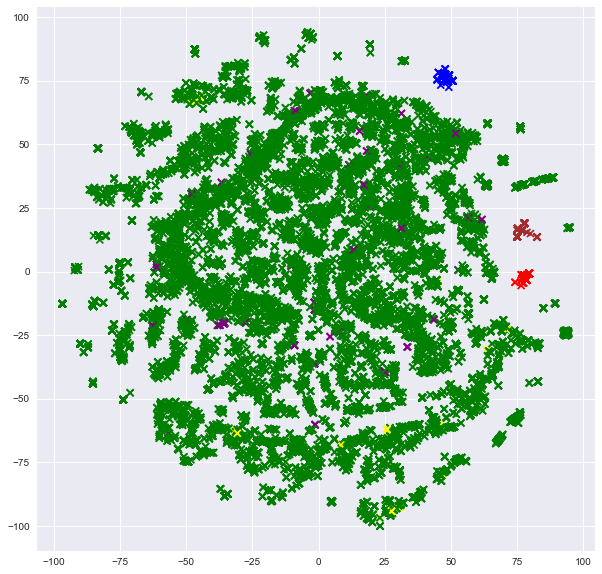

In [455]:
fig = plt.figure(figsize = (10, 10))
ax = plt.axes()
plt.scatter(tfs_embedded[:, 0], tfs_embedded[:, 1], marker = "x",c=colors)
plt.show()

#### Hierarchical Clustering

In [460]:
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import mpl_toolkits.mplot3d.axes3d as p3
from __future__ import print_function, division
from builtins import range
import time

In [457]:
###Lazy Programmer Method! Sample Data for Faster Results
X = tfidf_vectorizer.fit_transform(final_tweets).todense()
N = tfidf_matrix.shape[0]
idx = np.random.choice(N, size=5000, replace=False) # subsampe for efficiency
x = X[idx]

/Users/hector/anaconda/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


Condense our Matrix into array for visualizations

In [458]:
#dist_array = pdist(x) ## Euclidean dist

In [461]:
dist_array2 = pdist(x, 'cosine') ## Cosine dist

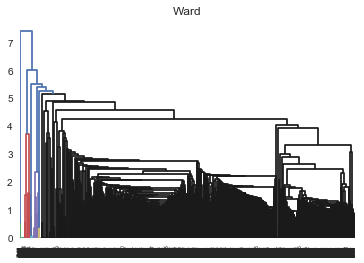

In [463]:
Z = linkage(dist_array2, 'ward')
plt.title("Ward")
dendrogram(Z,)
plt.savefig('Dendogram.png')
plt.show()

SKLearn method of visualizing 3-D hierarchical clustering

In [464]:
print("Compute unstructured hierarchical clustering...")
st = time.time()
ward = AgglomerativeClustering(n_clusters=6, linkage='ward').fit(x)
elapsed_time = time.time() - st
label = ward.labels_
print("Elapsed time: %.2fs" % elapsed_time)
print("Number of points: %i" % label.size)

Compute unstructured hierarchical clustering...
Elapsed time: 353.40s
Number of points: 5000


In [581]:
len(final_tweets)

45150